In [1]:
# Libraries

import argparse
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Washburn2019r
from source.python.cnn.models import Washburn2019c

from source.python.dataset import dataset_split
from source.python.dataset import dataset_utils
from source.python.cnn     import cnn_model
from source.python.cnn     import cnn_mutation
from source.python.cnn     import cnn_plot
from source.python.cnn     import cnn_utils
from source.python.io      import loader
from source.python.io      import writer
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Define output and inputs

FILTER_ID      = 1
VERBOSE        = False
FEATURES       = True
GENERATOR      = 'group'

MODEL_MODE     = 'regression'
MODEL_PARAMS   = 0
MODEL_EPOCHS   = 10

TARGET_GROUP   = 'global'
TARGET_TYPE    = 'mean'
TARGET_EXPLODE = False
TARGET_FILTER  = None

SEQUENCE_TYPE  = '5k'
SEQUENCE_END   = None
SEQUENCE_START = None

In [5]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)
	int_or_none = lambda x : None if x == 'none' else int(x)

	_target_groups    = ['tissue', 'group', 'age', 'global', 'perturbation']
	_target_types     = ['mean', 'max']
	_model_modes      = ['regression', 'classification']
	_split_generators = ['stratified', 'group', 'random']
	_sequence_types   = ['5k', '1k']

	parser.add_argument('--target_group',   type = str,         default = 'global',     choices = _target_groups)
	parser.add_argument('--target_type',    type = str,         default = 'mean',       choices = _target_types)
	parser.add_argument('--target_explode', type = str_of_bool, default = False)
	parser.add_argument('--target_filter',  type = str_or_none, default = None)
	parser.add_argument('--model_epochs',   type = int,         default = 250)
	parser.add_argument('--model_params',   type = int_or_none, default = None)
	parser.add_argument('--model_mode',     type = str,         default = 'regression', choices = _model_modes)
	parser.add_argument('--filter_id',      type = int,         default = 0)
	parser.add_argument('--generator',      type = str,         default = 'group',      choices = _split_generators)
	parser.add_argument('--features',       type = str_of_bool, default = False)
	parser.add_argument('--sequence_start', type = int_or_none, default = None)
	parser.add_argument('--sequence_end',   type = int_or_none, default = None)
	parser.add_argument('--sequence_type',  type = str,         default = '1k',         choices = _sequence_types)

	args = vars(parser.parse_args())

	TARGET_GROUP   = args['target_group']
	TARGET_TYPE    = args['target_type']
	TARGET_EXPLODE = args['target_explode']
	TARGET_FILTER  = args['target_filter']
	MODEL_EPOCHS   = args['model_epochs']
	MODEL_PARAMS   = args['model_params']
	MODEL_MODE     = args['model_mode']
	FILTER_ID      = args['filter_id']
	GENERATOR      = args['generator']
	FEATURES       = args['features']
	SEQUENCE_START = args['sequence_start']
	SEQUENCE_END   = args['sequence_end']
	SEQUENCE_TYPE  = args['sequence_type']

if TARGET_GROUP == 'global' :
	TARGET_EXPLODE = False

Running as .ipynb


In [6]:
# Setup some directory paths.

SUBFOLDER = 'filter' + str(FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp08-washburn',  SUBFOLDER, MODEL_MODE)
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP02 = os.path.join(OUT,      'nbp02-anndata', SUBFOLDER)
RES_NBP04 = os.path.join(OUT,      'nbp04-feature', SUBFOLDER)
RES_NBP05 = os.path.join(OUT,      'nbp05-target',  SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP02}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp08-washburn\filter1\regression
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp08-washburn\filter1\regression\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp08-washburn\filter1\regression\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter1
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter1
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter1


In [7]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 11.567 GB


In [8]:
# Define sequence paths

if SEQUENCE_TYPE == '5k' :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-6150-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-6150-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequence-6150.fasta')

if SEQUENCE_TYPE == '1k' :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-2150-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-2150-drop.fasta')
	mutation_keep = os.path.join(RES_NBP04, 'mutation-sequence-2150.fasta')

In [9]:
# Load the input transcript features

sequence_keep = loader.load_fasta(
	filename  = sequence_keep,
	to_string = True
)

sequence_drop = loader.load_fasta(
	filename  = sequence_drop,
	to_string = True
)

mutation_sequence = loader.load_fasta(
	filename  = mutation_keep,
	to_string = True
)

mutation_feature_base = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-base.npz')
)

feature_base_keep = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-keep.npz')
)

feature_base_drop = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-drop.npz')
)

model_config = loader.load_json(
	filename = os.path.join(RES, 'tuner', 'washburn2019.json')
)

# 2. Config

In [10]:
# Create final report

final_report = dict()

In [11]:
# Single global config

CONFIG = {
	'core/device'                  : DEVICE,
	'core/random'                  : None,
	'core/rootdir'                 : ROOT,
	'core/verbose'                 : VERBOSE,
	'criterion/name'               : None,
	'criterion/reduction'          : 'mean',
	'dataset/batch/test'           : 32,
	'dataset/batch/train'          : 32,
	'dataset/batch/valid'          : 32,
	'dataset/expanddim'            : 0,
	'dataset/sequence/start'       : SEQUENCE_START,
	'dataset/sequence/end'         : SEQUENCE_END,
	'dataset/sequence/type'        : SEQUENCE_TYPE,
	'dataset/split/generator'      : GENERATOR,
	'dataset/split/test'           : 0.2,
	'dataset/split/valid'          : 0.2,
	'model/conv1/dilation'         : None,
	'model/conv1/filters'          : None,
	'model/conv1/kernel'           : None,
	'model/conv1/padding'          : None,
	'model/conv2/dilation'         : None,
	'model/conv2/filters'          : None,
	'model/conv2/kernel'           : None,
	'model/conv2/padding'          : None,
	'model/conv3/dilation'         : None,
	'model/conv3/filters'          : None,
	'model/conv3/kernel'           : None,
	'model/conv3/padding'          : None,
	'model/conv4/dilation'         : None,
	'model/conv4/filters'          : None,
	'model/conv4/kernel'           : None,
	'model/conv4/padding'          : None,
	'model/conv5/dilation'         : None,
	'model/conv5/filters'          : None,
	'model/conv5/kernel'           : None,
	'model/conv5/padding'          : None,
	'model/conv6/dilation'         : None,
	'model/conv6/dilation'         : None,
	'model/conv6/filters'          : None,
	'model/conv6/kernel'           : None,
	'model/conv6/padding'          : None,
	'model/dropout'                : 0.09,
	'model/epochs'                 : MODEL_EPOCHS,
	'model/fc1/features'           : None,
	'model/fc2/features'           : None,
	'model/fc3/features'           : None,
	'model/fc3/heads'              : None,
	'model/features'               : FEATURES,
	'model/input/channels'         : 1,
	'model/input/features'         : None,
	'model/input/height'           : 4,
	'model/input/width'            : 2150,
	'model/leakyrelu'              : 0.0,
	'model/maxpool1/kernel'        : None,
	'model/maxpool1/padding'       : None,
	'model/maxpool2/kernel'        : None,
	'model/maxpool2/padding'       : None,
	'model/maxpool3/kernel'        : None,
	'model/maxpool3/padding'       : None,
	'model/mode'                   : MODEL_MODE,
	'model/output/explode'         : TARGET_EXPLODE,
	'model/output/filter'          : TARGET_FILTER,
	'model/output/heads'           : None,
	'model/output/size'            : None,
	'model/output/target'          : TARGET_GROUP,
	'model/output/type'            : TARGET_TYPE,
	'model/params/id'              : MODEL_PARAMS,
	'optimizer/beta1'              : 0.661281874650676338,
	'optimizer/beta2'              : 0.999000000000000000,
	'optimizer/decay'              : 0.000395388230840900,
	'optimizer/lr'                 : 0.001815871211166600,
	'optimizer/name'               : 'adam',
	'scheduler/exponential/factor' : 0.928799635208705565,
	'scheduler/linear/factor'      : 0.110989277168821301,
	'scheduler/name'               : 'exponential',
	'scheduler/plateau/factor'     : 0.353167198025807205,
	'scheduler/plateau/patience'   : 18
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

In [12]:
# Configure criterion

if CONFIG['model/mode'] == 'regression' :
	CONFIG['criterion/name'] = 'mse'

if CONFIG['model/mode'] == 'classification' :
	CONFIG['criterion/name'] = 'entropy'

In [13]:
# Update specific params

if CONFIG['model/params/id'] is not None and CONFIG['model/params/id'] >= 0 :
	CONFIG.update(model_config[CONFIG['model/params/id']])

In [14]:
# Prints

print('Output Target : {}'.format(CONFIG['model/output/target']))
print('Output Type   : {}'.format(CONFIG['model/output/type']))
print('Use Features  : {}'.format(CONFIG['model/features']))
print('Random Seed   : {}'.format(CONFIG['core/random']))

Output Target : global
Output Type   : mean
Use Features  : True
Random Seed   : 666361501


# 3. Dataloader

## 3.1 Normal

In [15]:
# Create dataset

dataset_keep, dataframe_keep, target_value_keep, target_order_keep = dataset_utils.get_dataset(
	config    = CONFIG,
	sequence  = sequence_keep,
	feature   = feature_base_keep,
	directory = RES_NBP05,
	cached    = None,
	start     = SEQUENCE_START,
	end       = SEQUENCE_END,
	filename  = 'mapping-grouped-keep.pkl'
)

dataset_drop, dataframe_drop, target_value_drop, target_order_drop = dataset_utils.get_dataset(
	config    = CONFIG,
	sequence  = sequence_drop,
	feature   = feature_base_drop,
	directory = RES_NBP05,
	cached    = None,
	start     = SEQUENCE_START,
	end       = SEQUENCE_END,
	filename  = 'mapping-grouped-drop.pkl'
)

print('Input Features : {}'.format(CONFIG['model/input/features']))
print('Output Size    : {}'.format(CONFIG['model/output/size']))
print('Output Heads   : {}'.format(CONFIG['model/output/heads']))

CONFIG['model/fc3/features'] = CONFIG['model/output/size']
CONFIG['model/fc3/heads']    = CONFIG['model/output/heads']

Input Features : 72
Output Size    : 1
Output Heads   : None


In [16]:
# Create dataloader

dataloaders_keep = dataset_utils.to_dataloaders(
	dataset     = dataset_keep,
	generator   = CONFIG['dataset/split/generator'],
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : CONFIG['dataset/split/valid'],
		'test'  : CONFIG['dataset/split/test']
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

train_dataloader_keep = dataloaders_keep[0]
valid_dataloader_keep = dataloaders_keep[1]
test_dataloader_keep  = dataloaders_keep[2]

dataloaders_drop = dataset_utils.to_dataloaders(
	dataset     = dataset_drop,
	generator   = CONFIG['dataset/split/generator'],
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : 0.0,
		'test'  : 0.0
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

test_dataloader_drop = dataloaders_drop[0]

In [17]:
# Display train dataloader

dataset_utils.show_dataloader(
	dataloader = train_dataloader_keep,
	verbose    = CONFIG['core/verbose']
)

In [18]:
# Display valid dataloader

dataset_utils.show_dataloader(
	dataloader = valid_dataloader_keep,
	verbose    = CONFIG['core/verbose']
)

In [19]:
# Display test dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader_keep,
	verbose    = CONFIG['core/verbose']
)

In [20]:
# Display test dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader_drop,
	verbose    = CONFIG['core/verbose']
)

## 3.2 Mutation

In [21]:
# Update mutation features

if 'Feature' in dataframe_keep.columns :
	mutation_feature_base_new = dict()

	for x in mutation_feature_base.keys() :
		df = dataframe_keep.loc[dataframe_keep['Transcript'] == x.split('-')[0]]

		for index, row in df.iterrows() :
			key = index + '-' + x.split('-')[-1]
			val = numpy.concatenate((mutation_feature_base[x], row['Feature']))

			mutation_feature_base_new[key] = val

	mutation_feature_base = mutation_feature_base_new

In [22]:
# Create mutation dataloader

mutation_dataloader = cnn_mutation.create_dataloader(
	sequences   = mutation_sequence,
	features    = mutation_feature_base,
	targets     = target_value_keep,
	expand_dims = CONFIG['dataset/expanddim'],
	start       = SEQUENCE_START,
	end         = SEQUENCE_END
)

In [23]:
# Display mutation dataloader

dataset_utils.show_dataloader(
	dataloader = mutation_dataloader,
	verbose    = CONFIG['core/verbose']
)

# 4. Model

## 4.1 Structure

In [24]:
# Create and display the model structure

if CONFIG['model/mode'] == 'regression'     : model = Washburn2019r(params = CONFIG)
if CONFIG['model/mode'] == 'classification' : model = Washburn2019c(params = CONFIG)

model.summary(
	batch_size  = CONFIG['dataset/batch/train'],
	in_channels = CONFIG['model/input/channels'],
	in_height   = CONFIG['model/input/height'],
	in_width    = CONFIG['model/input/width'],
	in_features = CONFIG['model/input/features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Washburn2019r                            [32, 1, 4, 6150]          [32, 1]                   --
├─Washburn2019: 1-1                      [32, 1, 4, 6150]          [32, 128]                 1,408
│    └─Conv2d: 2-1                       [32, 1, 4, 6150]          [32, 64, 3, 6150]         832
│    └─LeakyReLU: 2-2                    [32, 64, 3, 6150]         [32, 64, 3, 6150]         --
│    └─Conv2d: 2-3                       [32, 64, 3, 6150]         [32, 128, 3, 6150]        41,088
│    └─LeakyReLU: 2-4                    [32, 128, 3, 6150]        [32, 128, 3, 6150]        --
│    └─MaxPool2d: 2-5                    [32, 128, 3, 6150]        [32, 128, 3, 1230]        --
│    └─Dropout: 2-6                      [32, 128, 3, 1230]        [32, 128, 3, 1230]        --
│    └─Conv2d: 2-7                       [32, 128, 3, 1230]        [32, 128, 3, 1230]        82,048
│    └─LeakyReLU: 2-8  

In [25]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Metrics

In [26]:
# Define metrics

if CONFIG['model/mode'] == 'regression' :
	METRICS = {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'mape'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mape'),
		'wmape' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'wmape'),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2', output_size = CONFIG['model/output/size']),
	}

if CONFIG['model/mode'] == 'classification' :
	METRICS = {
		'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
		'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy', n_classes = CONFIG['model/output/size']),
		'auroc'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'auroc',    n_classes = CONFIG['model/output/size']),
		'f1'       : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'f1',       n_classes = CONFIG['model/output/size']),
		'matthews' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'matthews', n_classes = CONFIG['model/output/size'])
	}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

## 4.3 Parameters

In [27]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG,
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'savetime'  : os.path.join(OUT_MODEL, f'{model.__name__}-time.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader_keep,
	'valid_dataloader' : valid_dataloader_keep,
	'test_dataloader'  : test_dataloader_keep
}

## 4.4 Train

In [28]:
# Train and validate the model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.train_regressor(
		model  = model,
		params = model_params
	)

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.train_classifier(
		model  = model,
		params = model_params
	)

## 4.5 Visualization

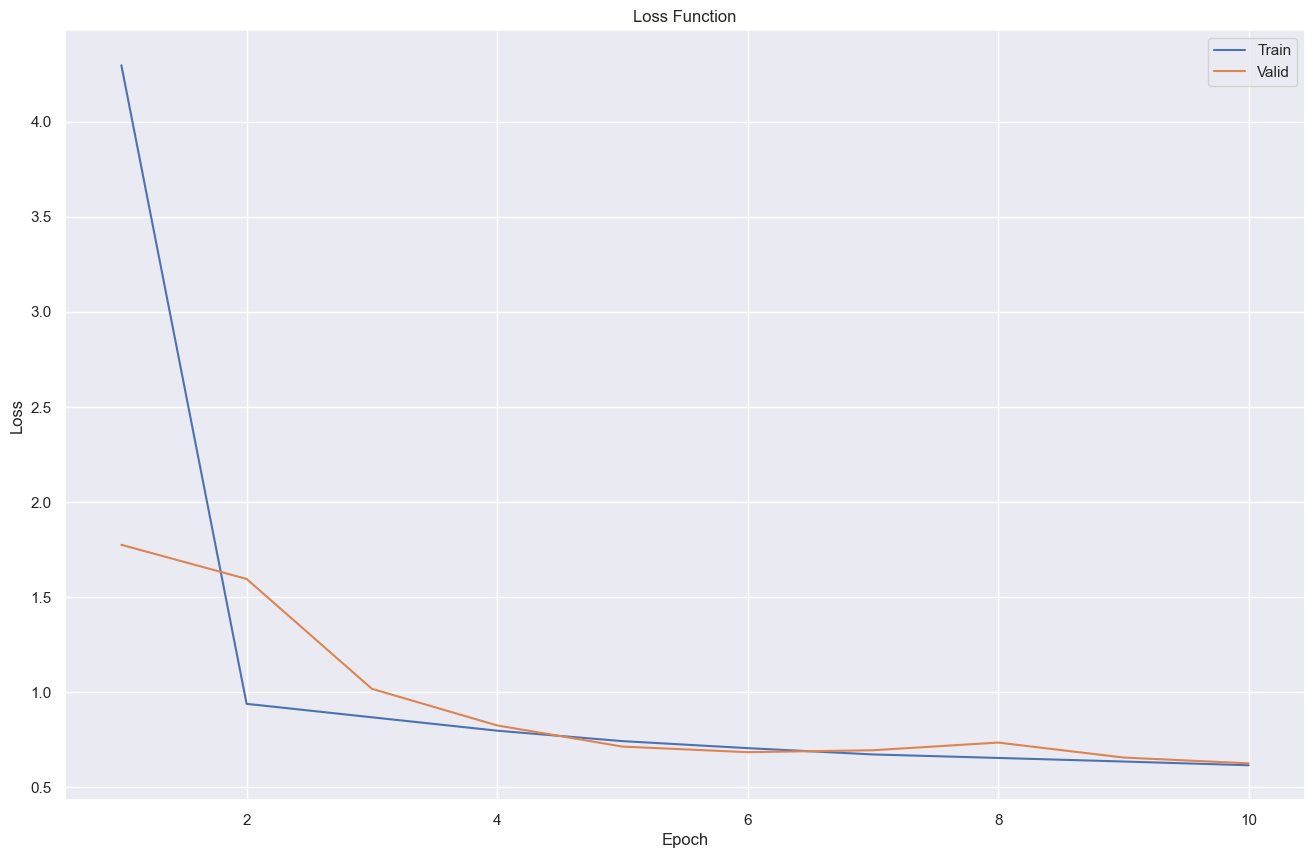

In [29]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report    = report,
	title     = 'Loss Function',
	filename  = os.path.join(OUT_PLOT, model.__name__),
	limit_bot = None,
	limit_top = None
)

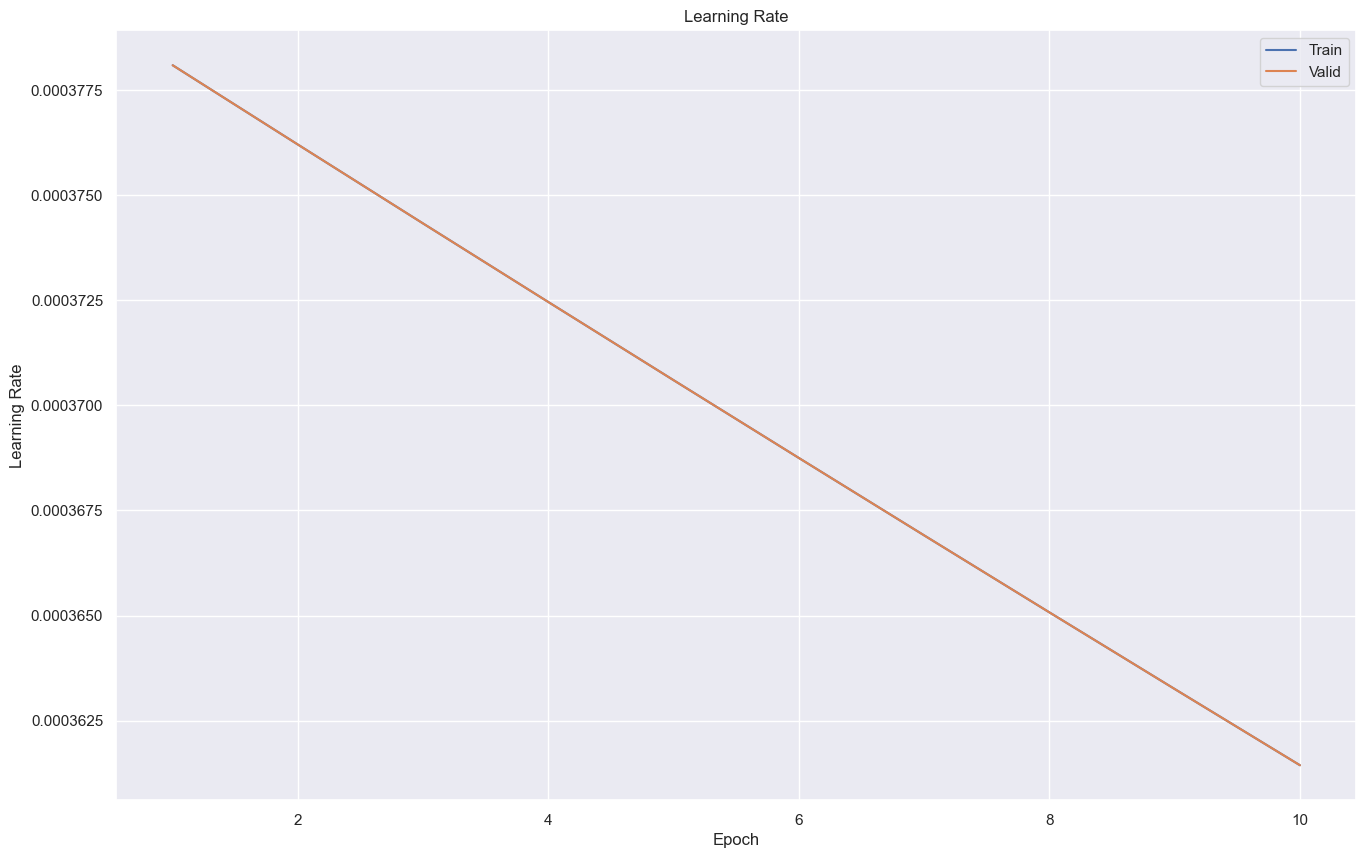

In [30]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report    = report,
	title     = 'Learning Rate',
	filename  = os.path.join(OUT_PLOT, model.__name__),
	limit_bot = None,
	limit_top = None
)

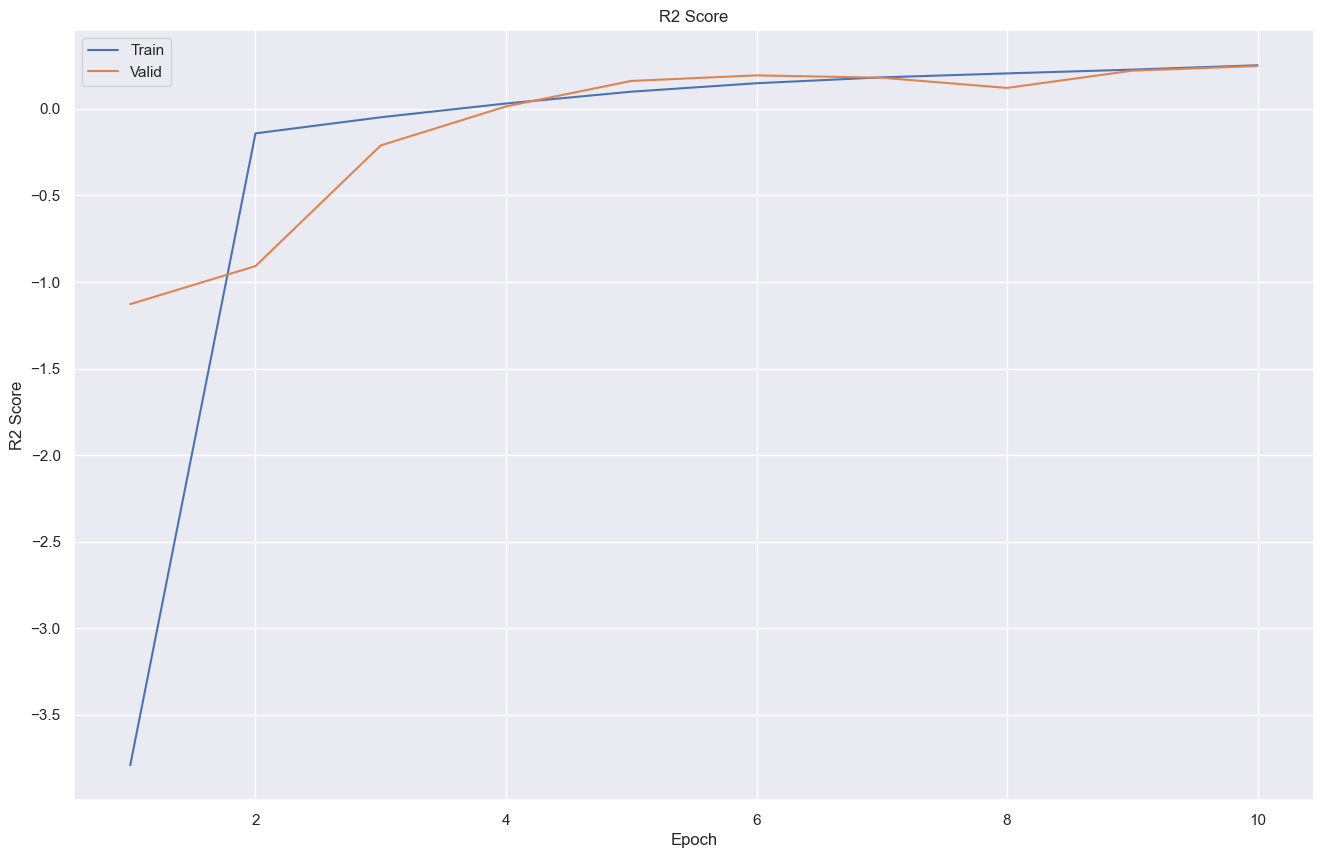

In [31]:
# Display the training and validation accuracy or r2 curves

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_r2(
		report    = report,
		title     = 'R2 Score',
		filename  = os.path.join(OUT_PLOT, model.__name__),
		limit_bot = None,
		limit_top = None
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.show_accuracy(
		report    = report,
		title     = 'Accuracy',
		filename  = os.path.join(OUT_PLOT, model.__name__),
		limit_bot = None,
		limit_top = None
	)

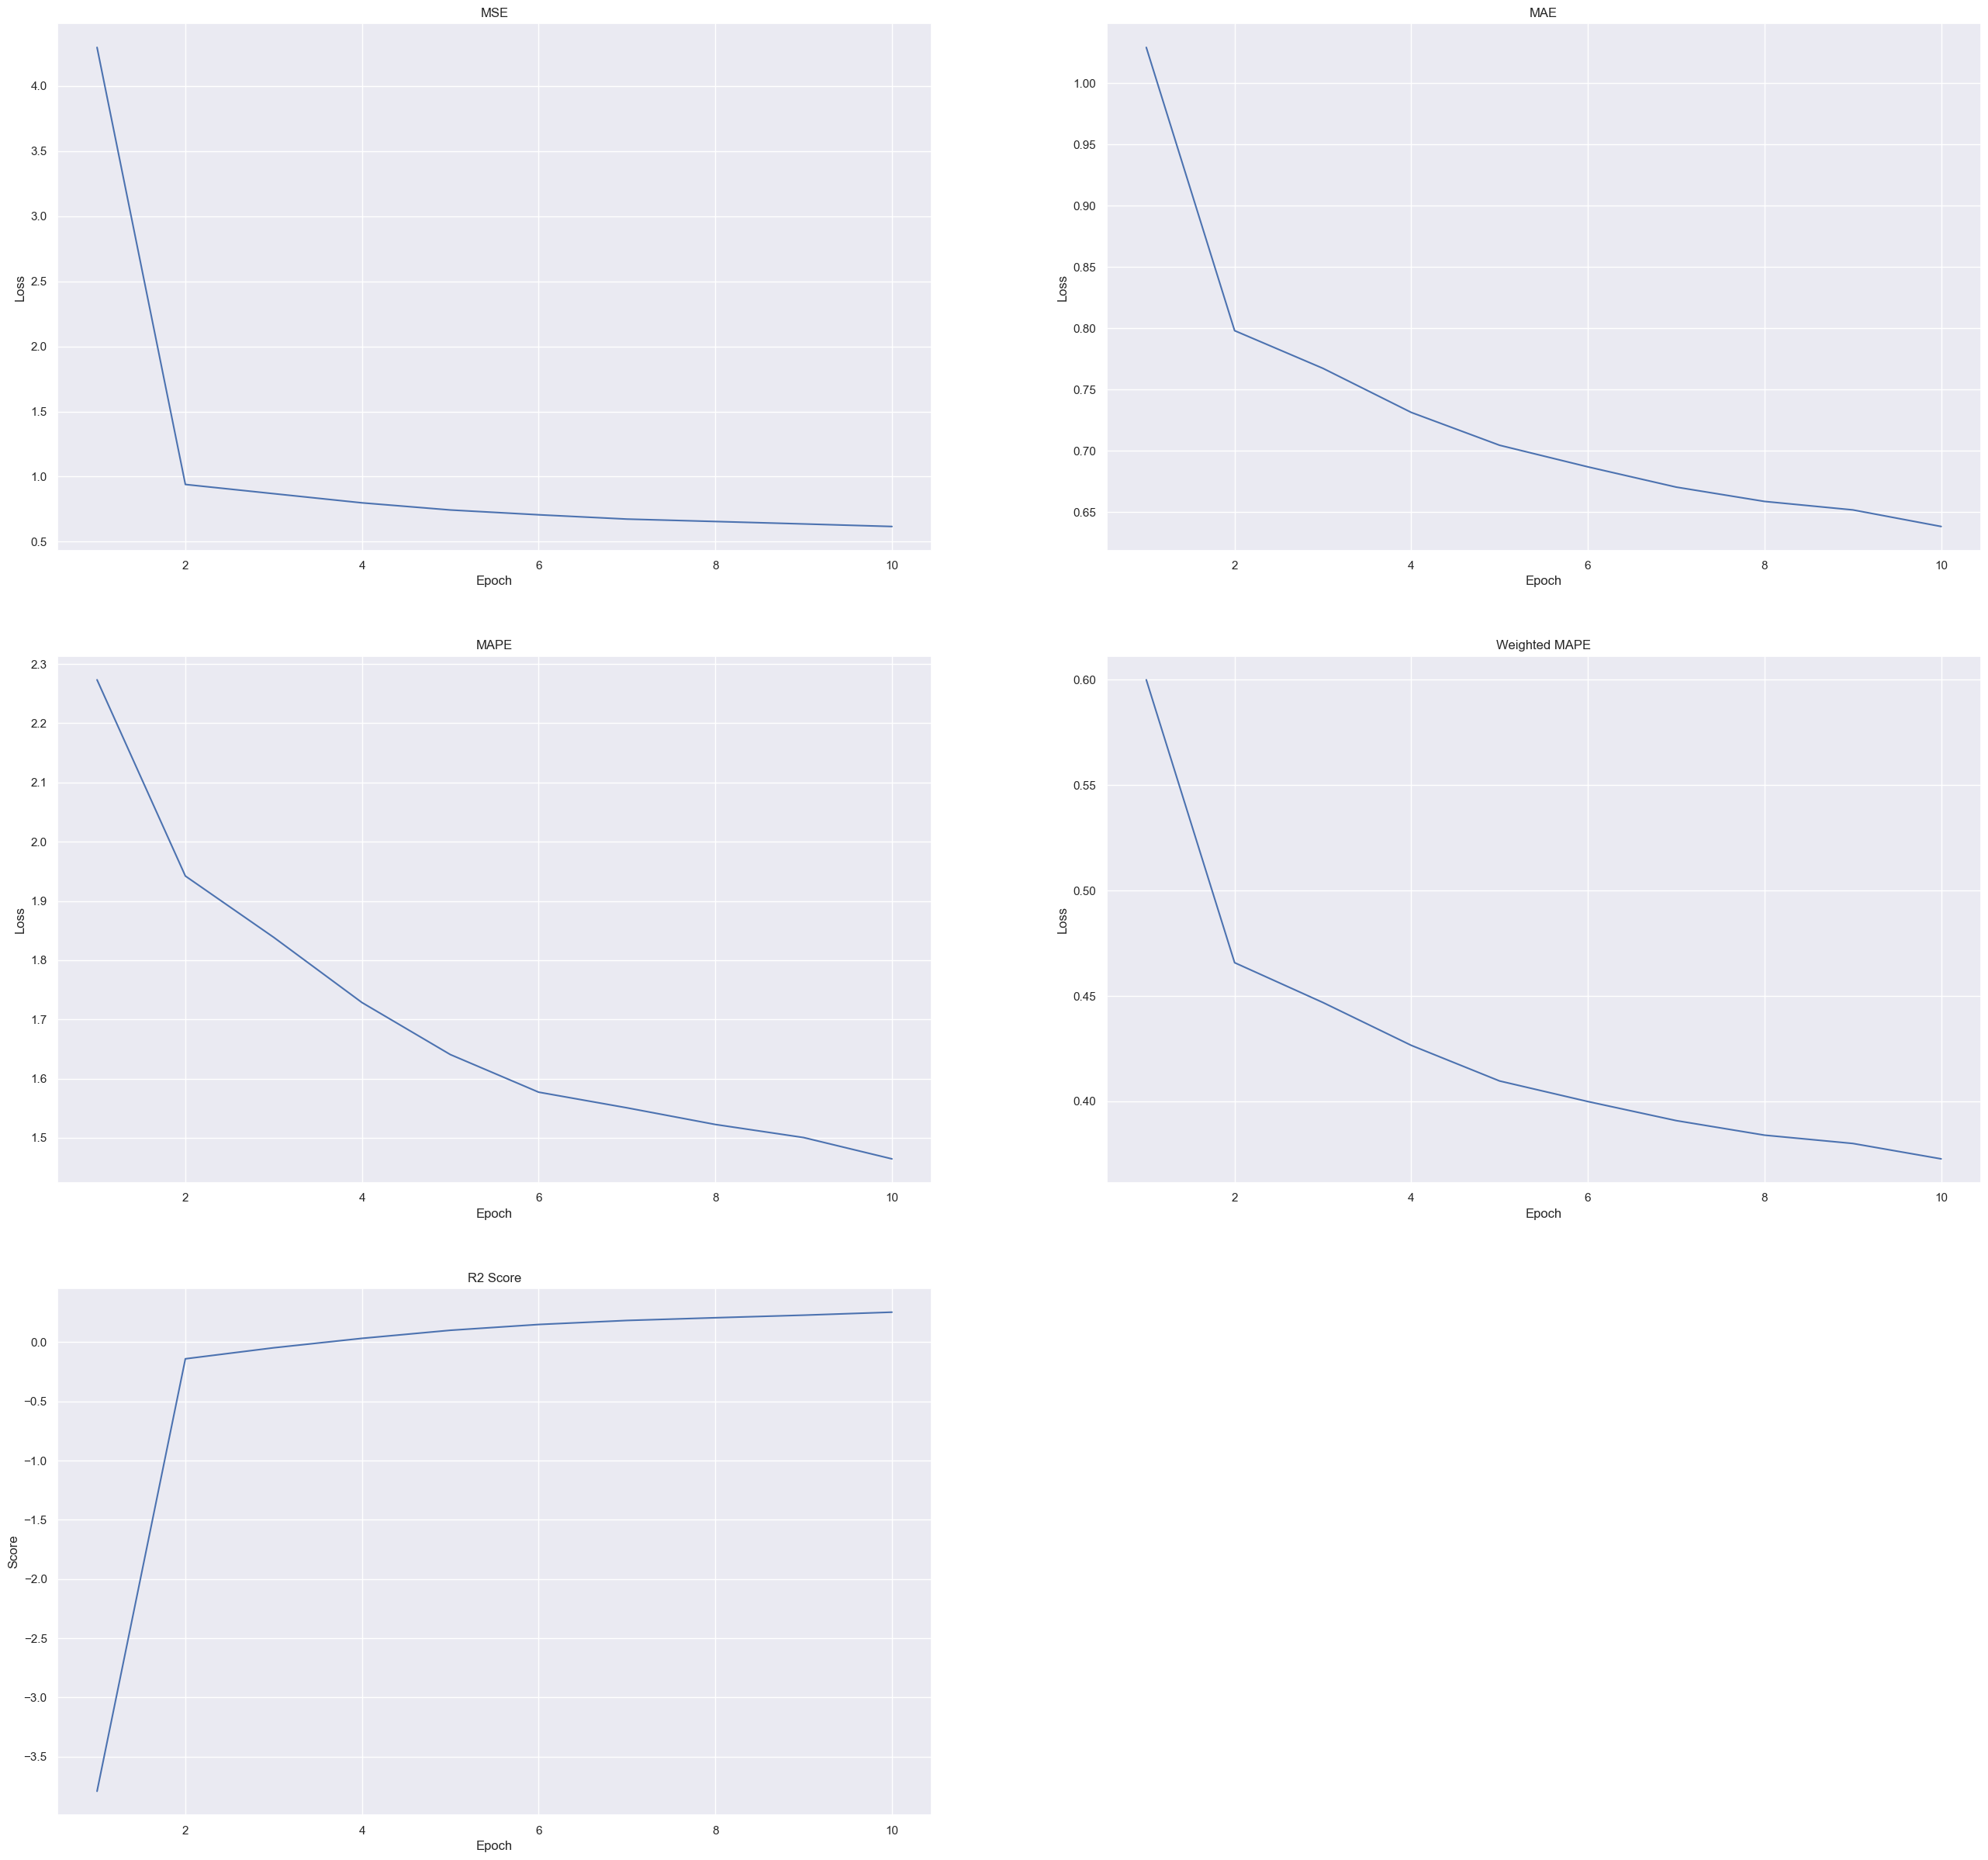

In [32]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'train',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-train'),
	apply_limits = False
)

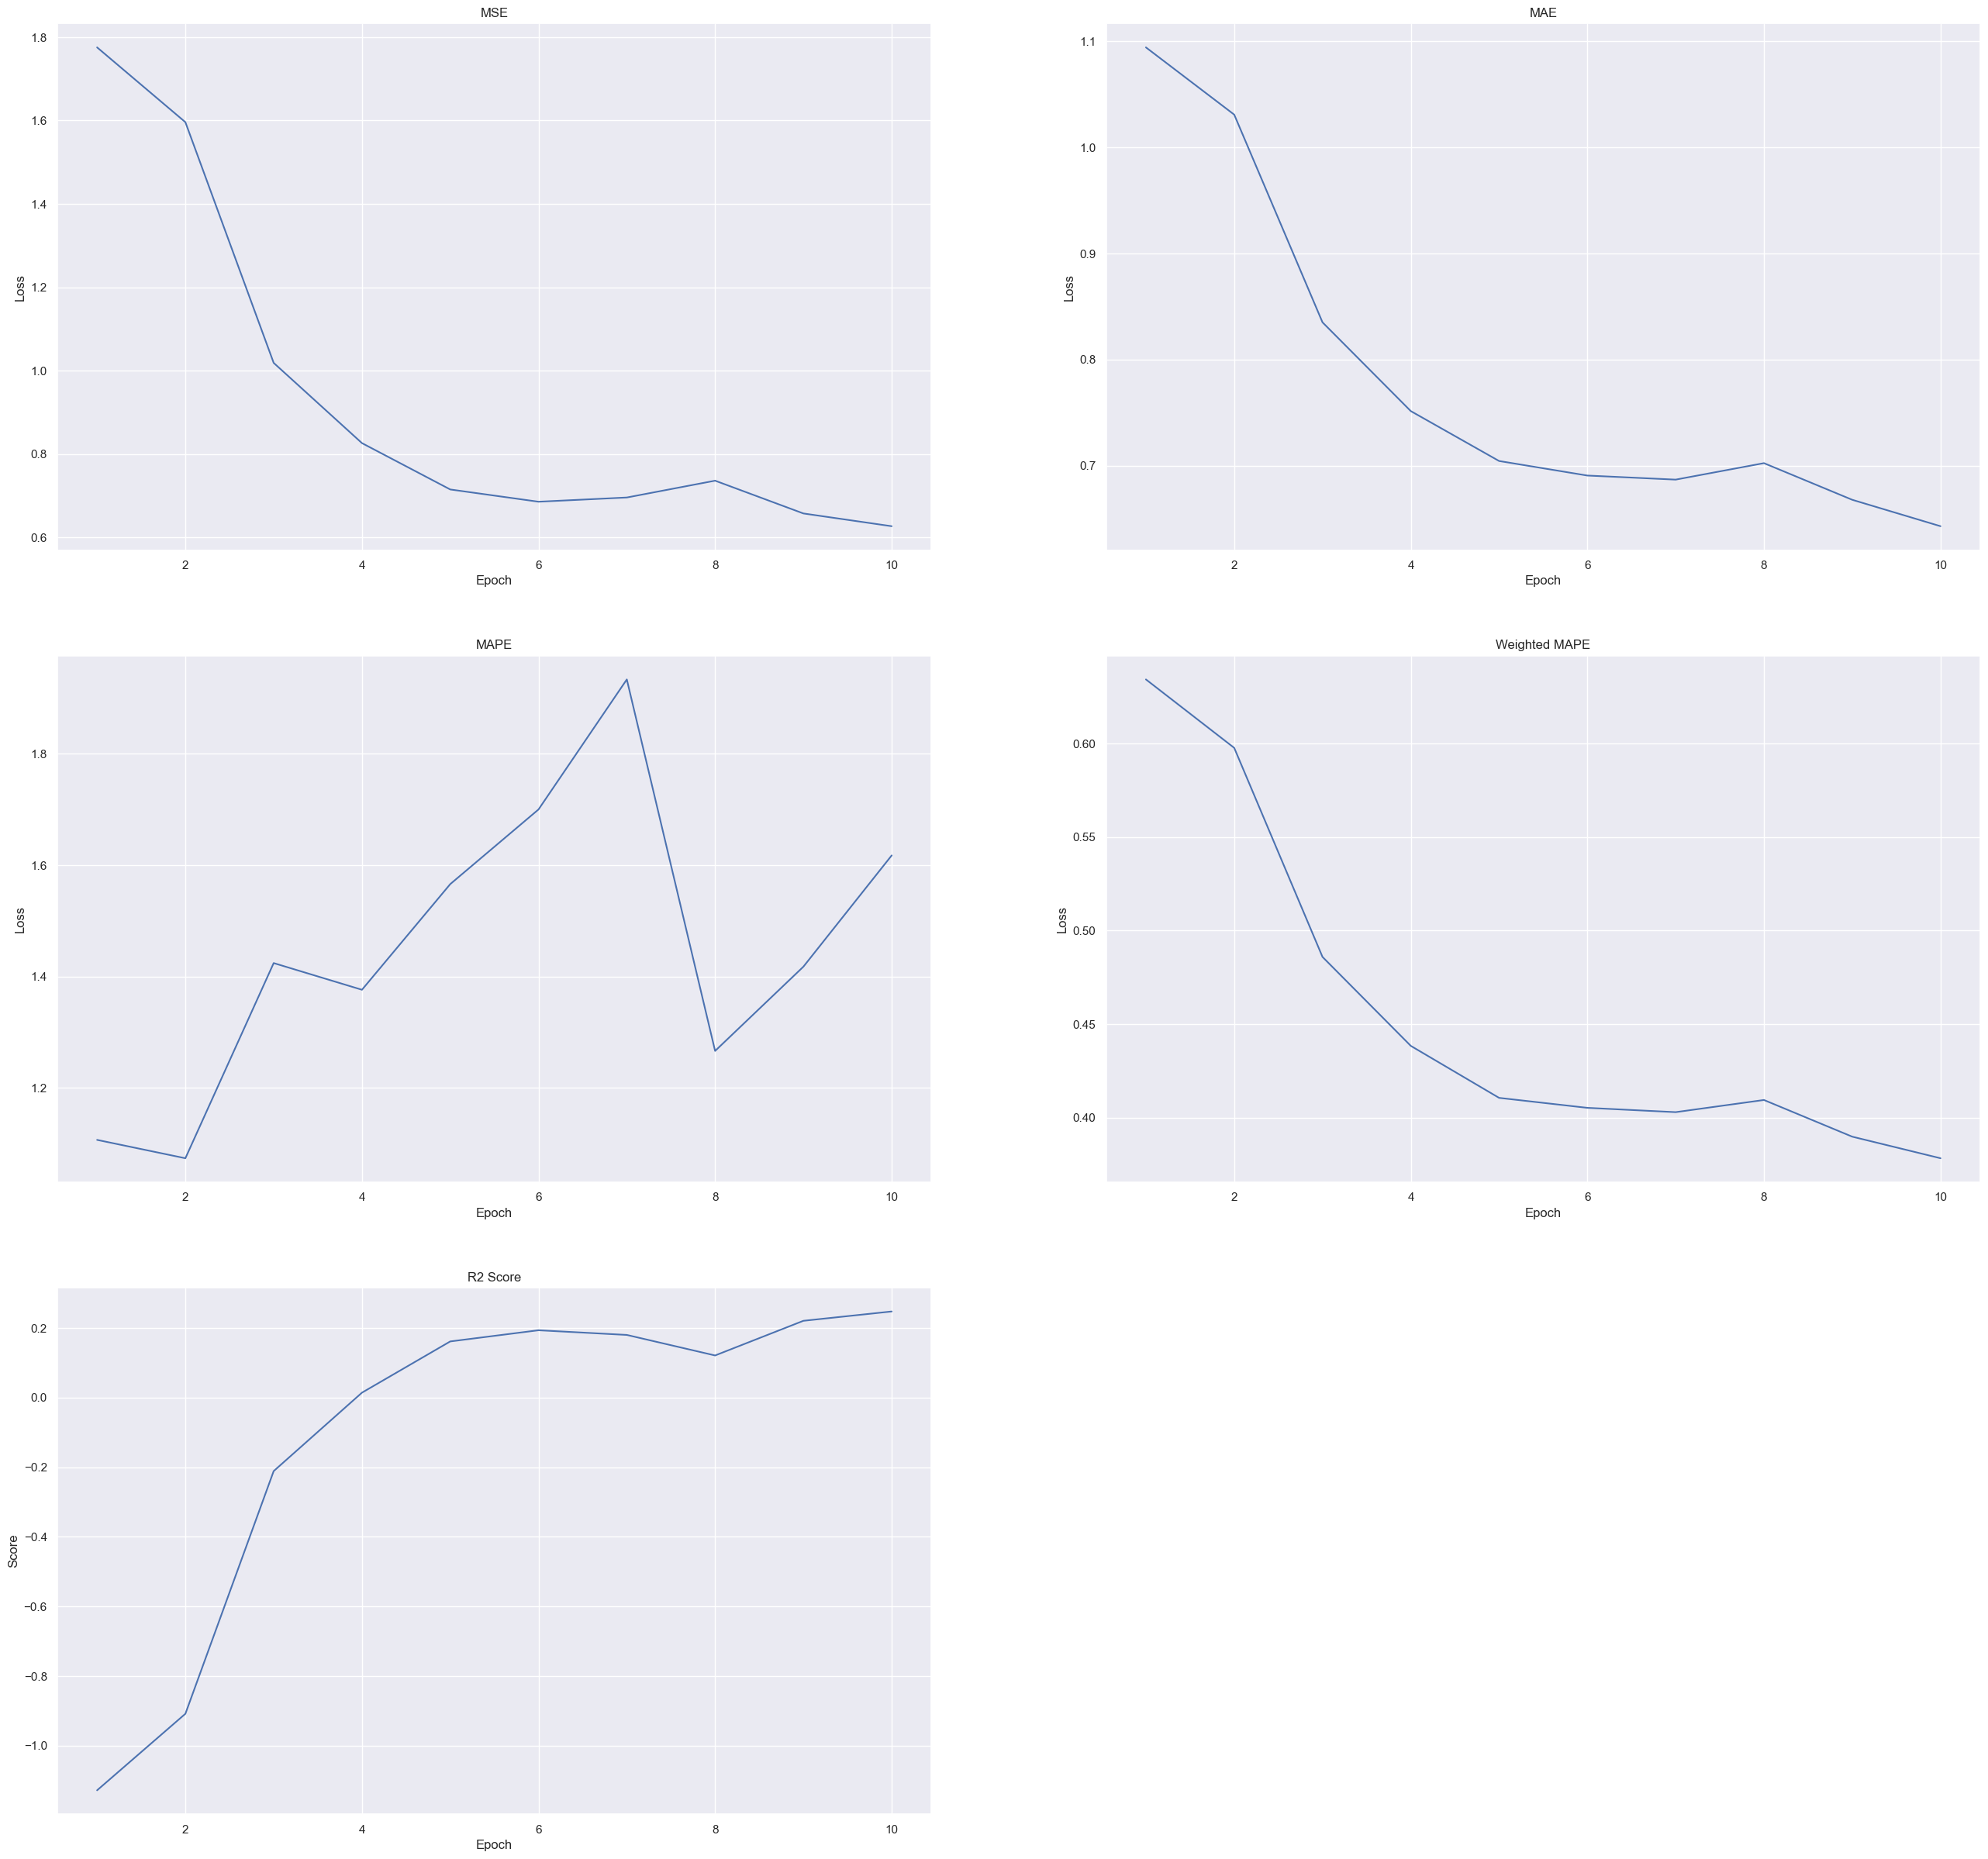

In [33]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'valid',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-valid'),
	apply_limits = False
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [34]:
# Load last model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

final_report['evaluation/last/epoch'] = checkpoint['epoch']
final_report['evaluation/last/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 10
 Loss : 0.62663


<All keys matched successfully>

In [35]:
# Evaluate the full model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.eval_regressor(
		model  = model,
		params = model_params
	)

	final_report['evaluation/last/r2/mean']    = report['eval']['metric']['r2'].mean()
	final_report['evaluation/last/mae/mean']   = report['eval']['metric']['mae'].mean()
	final_report['evaluation/last/mse/mean']   = report['eval']['metric']['mse'].mean()
	final_report['evaluation/last/mape/mean']  = report['eval']['metric']['mape'].mean()
	final_report['evaluation/last/wmape/mean'] = report['eval']['metric']['wmape'].mean()

	print('  R2 Score : ' + '{: 9.5f}'.format(final_report['evaluation/last/r2/mean']))
	print('  MAE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/last/mae/mean']))
	print('  MSE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/last/mse/mean']))
	print(' MAPE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/last/mape/mean']))
	print('WMAPE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/last/wmape/mean']))

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.eval_classifier(
		model  = model,
		params = model_params
	)

	final_report['evaluation/last/accuracy/mean'] = report['eval']['metric']['accuracy'].mean()
	final_report['evaluation/last/entropy/mean']  = report['eval']['metric']['entropy'].mean()
	final_report['evaluation/last/auroc/mean']    = report['eval']['metric']['auroc'].mean()
	final_report['evaluation/last/f1/mean']       = report['eval']['metric']['f1'].mean()
	final_report['evaluation/last/matthews/mean'] = report['eval']['metric']['matthews'].mean()

	print('Accuracy : ' + '{: 9.5f}'.format(final_report['evaluation/last/accuracy/mean']))
	print('Entropy  : ' + '{: 9.5f}'.format(final_report['evaluation/last/entropy/mean']))
	print('Auroc    : ' + '{: 9.5f}'.format(final_report['evaluation/last/auroc/mean']))
	print('F1       : ' + '{: 9.5f}'.format(final_report['evaluation/last/f1/mean']))
	print('Matthews : ' + '{: 9.5f}'.format(final_report['evaluation/last/matthews/mean']))

  R2 Score :   0.28322
  MAE Loss :   0.63247
  MSE Loss :   0.59964
 MAPE Loss :   1.56850
WMAPE Loss :   0.37038


## 5.2 Best Model

### 5.2.1 Evaluation

In [36]:
# Load best model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

final_report['evaluation/best/epoch'] = checkpoint['epoch']
final_report['evaluation/best/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 10
 Loss : 0.62663


<All keys matched successfully>

In [37]:
# Evaluate the full model

if CONFIG['model/mode'] == 'regression' :
	report_keep = cnn_model.eval_regressor(
		model  = model,
		params = model_params
	)

	final_report['evaluation/best/r2/mean']    = report_keep['eval']['metric']['r2'].mean()
	final_report['evaluation/best/mae/mean']   = report_keep['eval']['metric']['mae'].mean()
	final_report['evaluation/best/mse/mean']   = report_keep['eval']['metric']['mse'].mean()
	final_report['evaluation/best/mape/mean']  = report_keep['eval']['metric']['mape'].mean()
	final_report['evaluation/best/wmape/mean'] = report_keep['eval']['metric']['wmape'].mean()

	print('  R2 Score : ' + '{: 9.5f}'.format(final_report['evaluation/best/r2/mean']))
	print('  MAE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/best/mae/mean']))
	print('  MSE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/best/mse/mean']))
	print(' MAPE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/best/mape/mean']))
	print('WMAPE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/best/wmape/mean']))

if CONFIG['model/mode'] == 'classification' :
	report_keep = cnn_model.eval_classifier(
		model  = model,
		params = model_params
	)

	final_report['evaluation/best/accuracy/mean'] = report_keep['eval']['metric']['accuracy'].mean()
	final_report['evaluation/best/entropy/mean']  = report_keep['eval']['metric']['entropy'].mean()
	final_report['evaluation/best/auroc/mean']    = report_keep['eval']['metric']['auroc'].mean()
	final_report['evaluation/best/f1/mean']       = report_keep['eval']['metric']['f1'].mean()
	final_report['evaluation/best/matthews/mean'] = report_keep['eval']['metric']['matthews'].mean()

	print('Accuracy : ' + '{: 9.5f}'.format(final_report['evaluation/best/accuracy/mean']))
	print('Entropy  : ' + '{: 9.5f}'.format(final_report['evaluation/best/entropy/mean']))
	print('Auroc    : ' + '{: 9.5f}'.format(final_report['evaluation/best/auroc/mean']))
	print('F1       : ' + '{: 9.5f}'.format(final_report['evaluation/best/f1/mean']))
	print('Matthews : ' + '{: 9.5f}'.format(final_report['evaluation/best/matthews/mean']))

  R2 Score :   0.29035
  MAE Loss :   0.63240
  MSE Loss :   0.59957
 MAPE Loss :   1.56853
WMAPE Loss :   0.36968


In [38]:
# Evaluate the full model

if CONFIG['model/mode'] == 'regression' :
	report_drop = cnn_model.eval_regressor(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_drop
		}
	)

	final_report['evaluation/drop/r2/mean']    = report_drop['eval']['metric']['r2'].mean()
	final_report['evaluation/drop/mae/mean']   = report_drop['eval']['metric']['mae'].mean()
	final_report['evaluation/drop/mse/mean']   = report_drop['eval']['metric']['mse'].mean()
	final_report['evaluation/drop/mape/mean']  = report_drop['eval']['metric']['mape'].mean()
	final_report['evaluation/drop/wmape/mean'] = report_drop['eval']['metric']['wmape'].mean()

	print('  R2 Score : ' + '{: 9.5f}'.format(final_report['evaluation/drop/r2/mean']))
	print('  MAE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/drop/mae/mean']))
	print('  MSE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/drop/mse/mean']))
	print(' MAPE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/drop/mape/mean']))
	print('WMAPE Loss : ' + '{: 9.5f}'.format(final_report['evaluation/drop/wmape/mean']))

if CONFIG['model/mode'] == 'classification' :
	report_drop = cnn_model.eval_classifier(
		model  = model,
		params = model_params | {
			'test_dataloader' : test_dataloader_drop
		}
	)

	final_report['evaluation/drop/accuracy/mean'] = report_drop['eval']['metric']['accuracy'].mean()
	final_report['evaluation/drop/entropy/mean']  = report_drop['eval']['metric']['entropy'].mean()
	final_report['evaluation/drop/auroc/mean']    = report_drop['eval']['metric']['auroc'].mean()
	final_report['evaluation/drop/f1/mean']       = report_drop['eval']['metric']['f1'].mean()
	final_report['evaluation/drop/matthews/mean'] = report_drop['eval']['metric']['matthews'].mean()

	print('Accuracy : ' + '{: 9.5f}'.format(final_report['evaluation/drop/accuracy/mean']))
	print('Entropy  : ' + '{: 9.5f}'.format(final_report['evaluation/drop/entropy/mean']))
	print('Auroc    : ' + '{: 9.5f}'.format(final_report['evaluation/drop/auroc/mean']))
	print('F1       : ' + '{: 9.5f}'.format(final_report['evaluation/drop/f1/mean']))
	print('Matthews : ' + '{: 9.5f}'.format(final_report['evaluation/drop/matthews/mean']))

  R2 Score : -80.87610
  MAE Loss :   1.16581
  MSE Loss :   1.62590
 MAPE Loss :  33.87134
WMAPE Loss :   7.57632


### 5.2.2 Custom

In [39]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_keep,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_keep,
		n      = 2
	)

 Key : AT3G13990.1
True : [ 1.53544]
Pred : [ 1.85303]
 MAE : [ 0.31760]
 MSE : [ 0.10087]
  R2 : [ 0.22991]

 Key : AT1G01590.1
True : [ 0.13477]
Pred : [ 1.14211]
 MAE : [ 1.00734]
 MSE : [ 1.01474]
  R2 : [ 0.54645]



### 5.2.3 Visualization

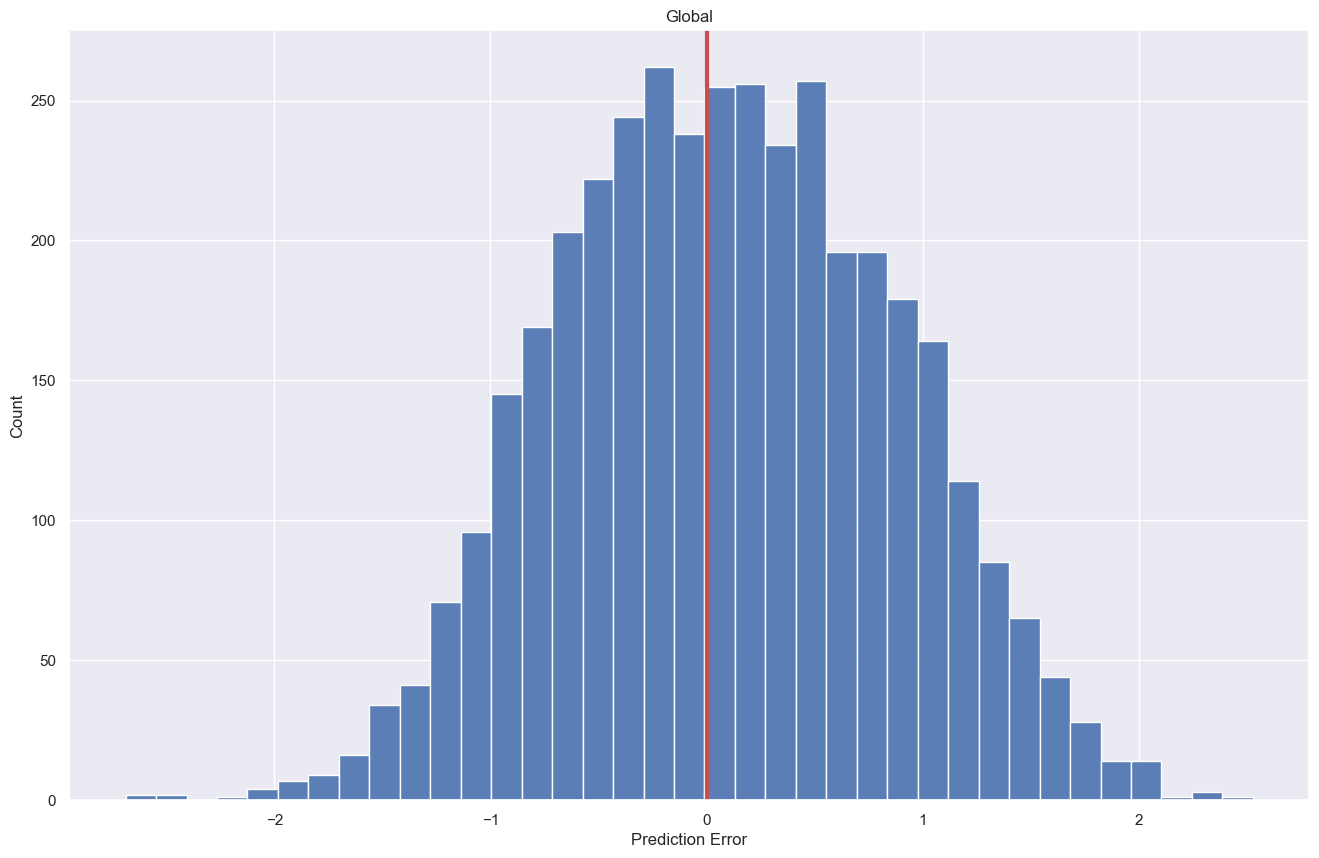

In [40]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_keep,
		order    = target_order_keep,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
	)

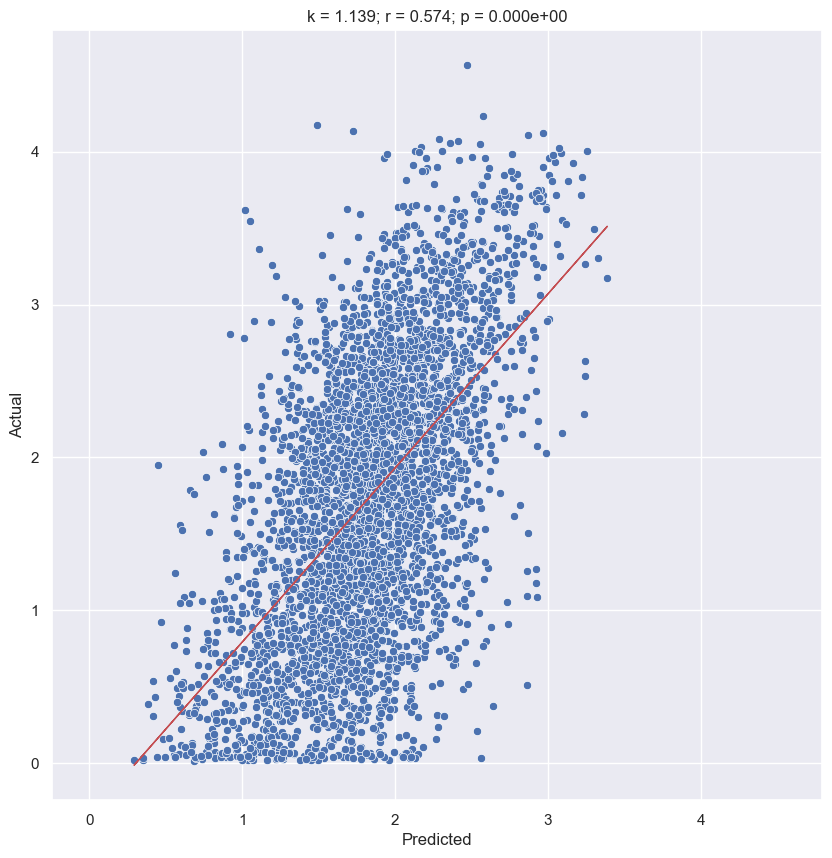

In [41]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_keep,
		order    = target_order_keep,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
	)

# 6 Mutation

## 6.1 Evaluation

In [42]:
# Evaluate the mutations

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.eval_regressor(
		model  = model,
		params = model_params | {
			'test_dataloader' : mutation_dataloader,
			'metrics' : {
				'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse').to(DEVICE),
				'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae').to(DEVICE)
			}
		}
	)

	final_report['mutation/best/mae/mean'] = report['eval']['metric']['mae'].mean()
	final_report['mutation/best/mse/mean'] = report['eval']['metric']['mse'].mean()

	print('MAE Loss : ' + '{: 9.5f}'.format(final_report['mutation/best/mae/mean']))
	print('MSE Loss : ' + '{: 9.5f}'.format(final_report['mutation/best/mse/mean']))

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.eval_classifier(
		model  = model,
		params = model_params | {
			'test_dataloader' : mutation_dataloader,
			'metrics' : {
				'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy' ).to(DEVICE),
				'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy', n_classes = CONFIG['model/output/size']).to(DEVICE)
			}
		}
	)

	final_report['mutation/best/accuracy/mean'] = report['eval']['metric']['accuracy'].mean()
	final_report['mutation/best/entropy/mean']  = report['eval']['metric']['entropy'].mean()

	print('Accuracy : ' + '{: 9.5f}'.format(final_report['mutation/best/accuracy/mean']))
	print('Entropy  : ' + '{: 9.5f}'.format(final_report['mutation/best/entropy/mean']))

MAE Loss :   0.96981
MSE Loss :   1.47497


In [43]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [44]:
# Print mutations

print(' ' + ' '.join('{:>20s}'.format(x) if i % 5 != 0 else '{:>20s}'.format(x) + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

          AT2G43710.1          AT1G07610.1          AT3G10985.1          AT5G18580.1          AT4G36900.1
          AT2G30432.1          AT3G11964.2          AT3G05800.1          AT1G12020.1          AT5G39550.1
          AT1G02980.1          AT5G01530.1          AT5G60870.3          AT1G73590.1          AT5G38200.1
          AT5G27610.1          AT5G35530.1          AT5G18470.1          AT2G07690.1          AT3G01513.1
          AT1G04440.1          AT5G64420.1          AT5G07430.1          AT1G14790.1          AT1G27370.1



## 6.2 Visualization

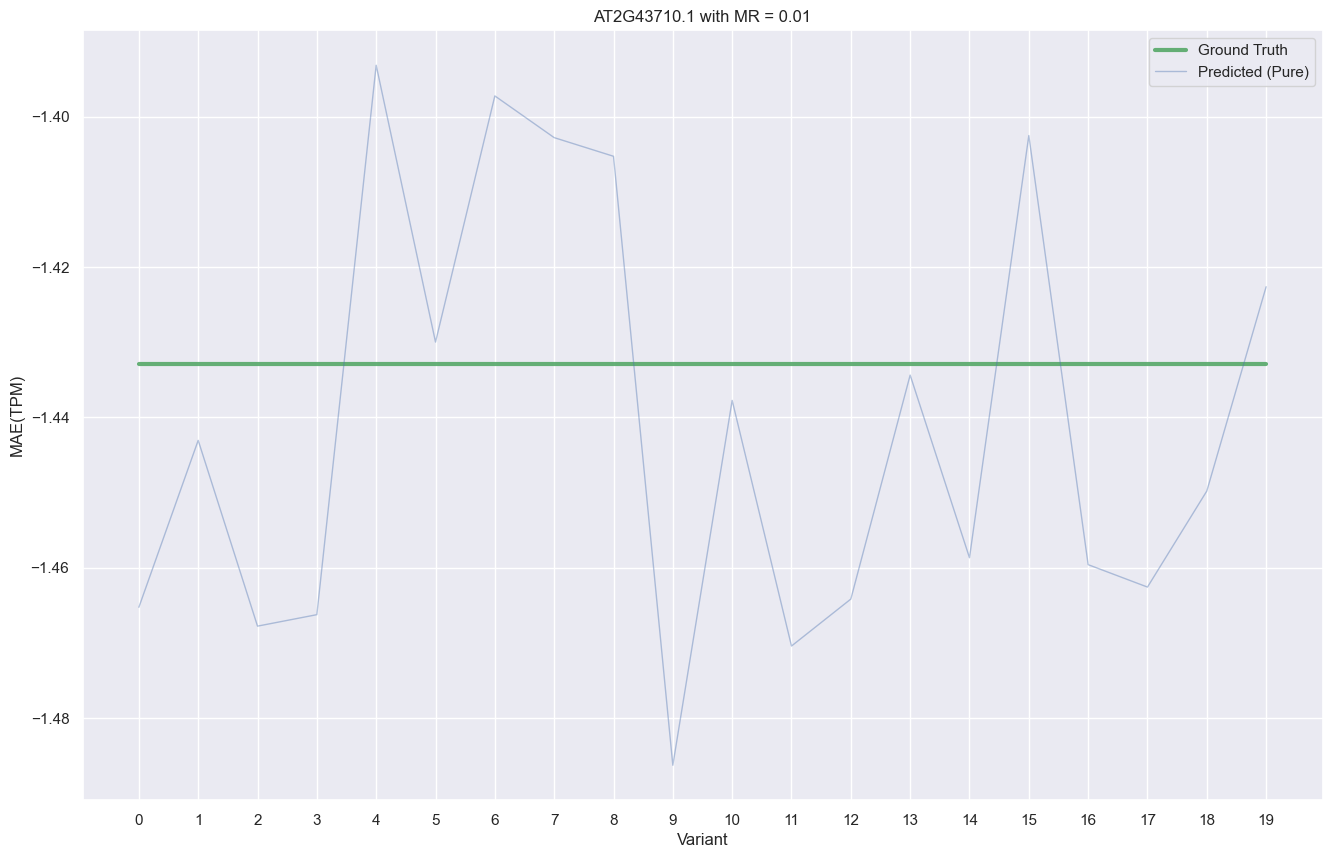

In [45]:
# Plot single transcript mutation variant predictions

if CONFIG['model/mode'] == 'regression' :
	cnn_mutation.plot_mutation_regression(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M01',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m01')
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_mutation.plot_mutation_classification(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M01',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m01')
	)

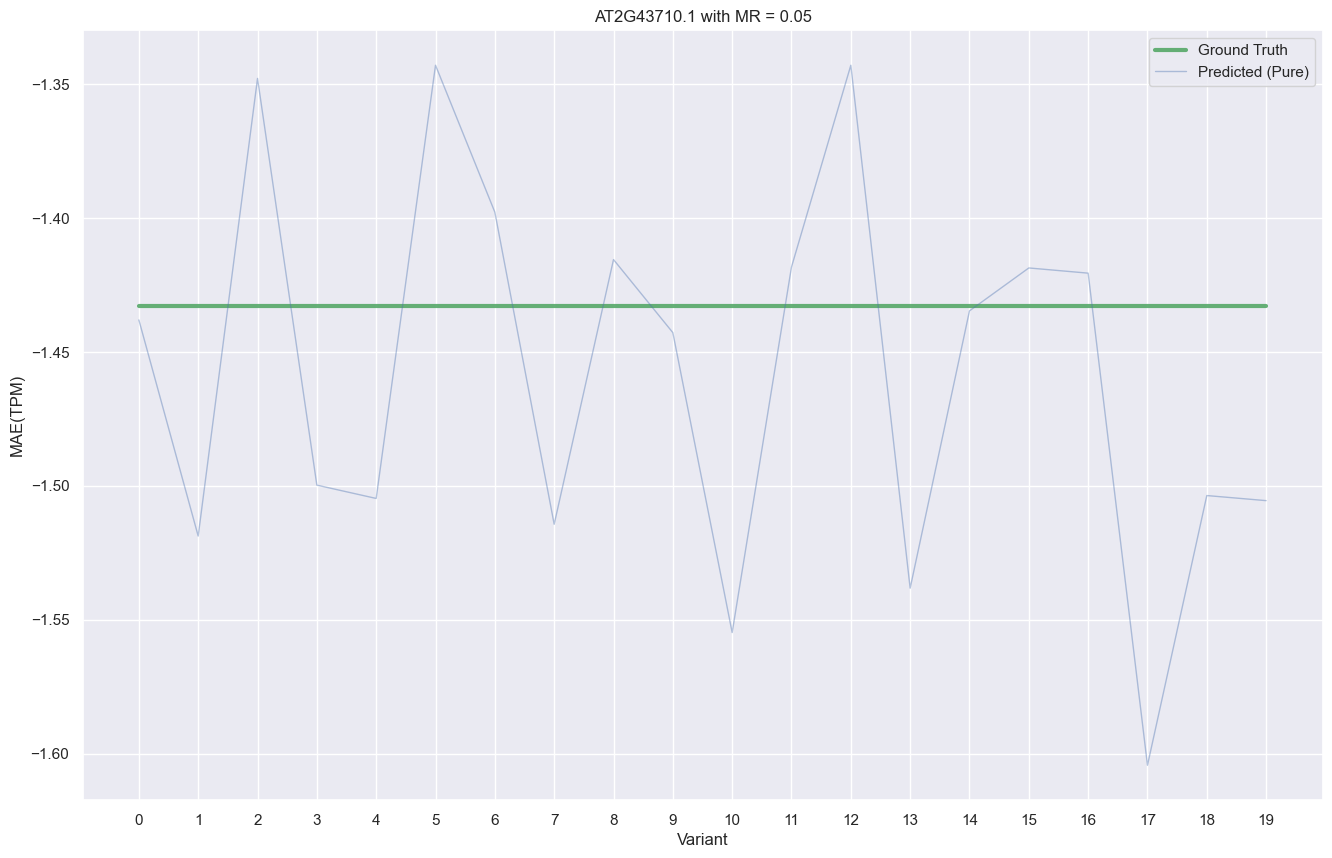

In [46]:
# Plot single transcript mutation variant predictions

if CONFIG['model/mode'] == 'regression' :
	cnn_mutation.plot_mutation_regression(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M05',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m05')
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_mutation.plot_mutation_classification(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M05',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m05')
	)

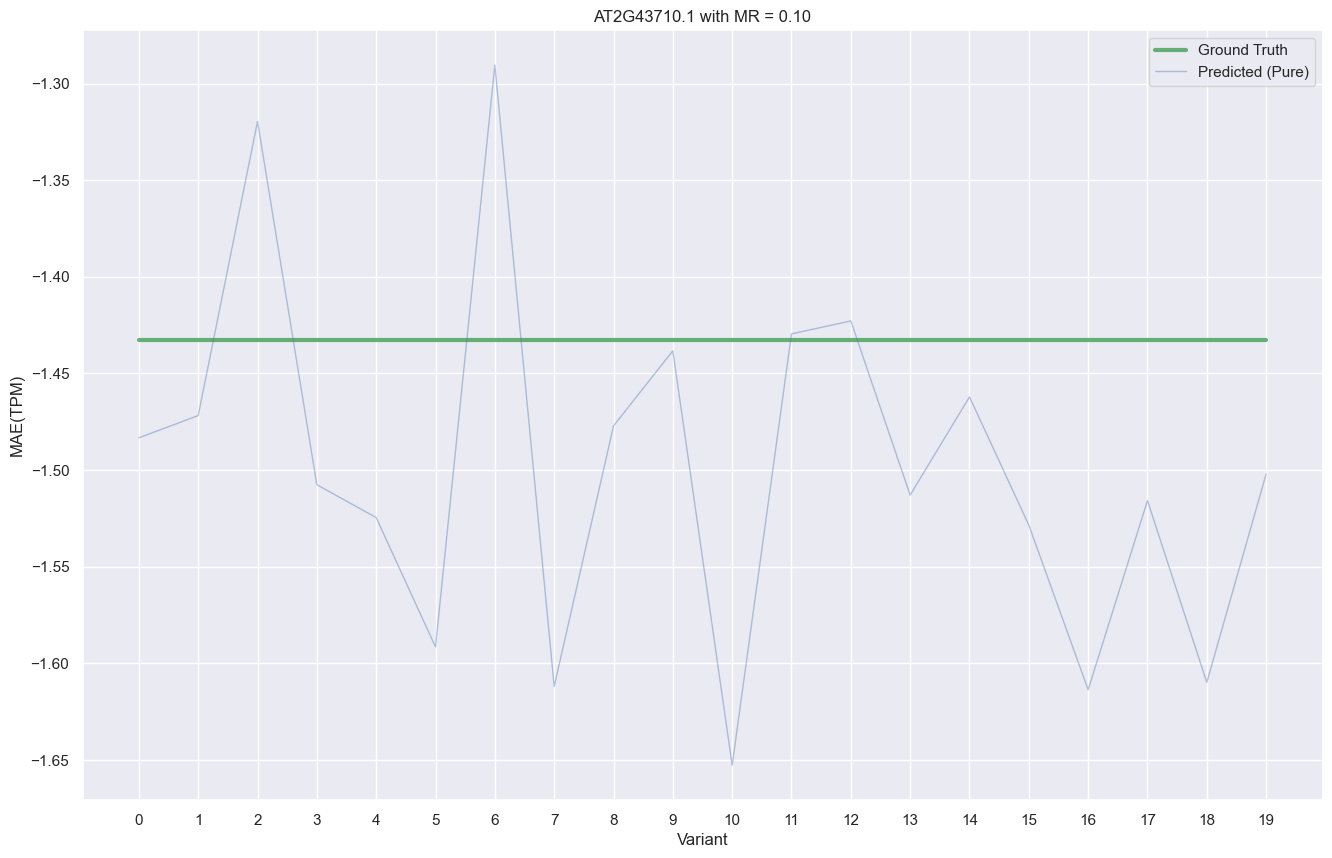

In [47]:
# Plot single transcript mutation variant predictions

if CONFIG['model/mode'] == 'regression' :
	cnn_mutation.plot_mutation_regression(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M10',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m10')
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_mutation.plot_mutation_classification(
		report     = mutation_report,
		transcript = None,
		mutation   = 'M10',
		order      = target_order_keep,
		filename   = os.path.join(OUT_PLOT, model.__name__ + '-mutation-m05')
	)

# 7. Save

In [48]:
# Convert reports from numpy array to lists

def ensure_json_validity (item) :
	if   isinstance(item, dict)          : pass
	elif isinstance(item, list)          : return item
	elif isinstance(item, numpy.ndarray) : return item.tolist()
	elif isinstance(item, float)         : return item
	elif isinstance(item, int)           : return item
	elif isinstance(item, str)           : return item
	else                                 : return None

	data = dict()

	for key in item.keys() :
		data[key] = ensure_json_validity(item[key])

	return data

report_keep = ensure_json_validity(report_keep)
report_drop = ensure_json_validity(report_drop)

In [49]:
# Save results

for key, value in final_report.items() :
	if isinstance(value, numpy.float32) :
		final_report[key] = float(value)

writer.write_json(
	data     = final_report,
	filename = os.path.join(OUT_DATA, 'report.json')
)

writer.write_json(
	data     = report_keep,
	filename = os.path.join(OUT_DATA, 'report_keep.json')
)

writer.write_json(
	data     = report_drop,
	filename = os.path.join(OUT_DATA, 'report_drop.json')
)

writer.write_json(
	data     = {k : v for k, v in CONFIG.items() if k != 'core/device'},
	filename = os.path.join(OUT_DATA, 'config.json')
)